# Task 2: Data Preparation
 
**Objective:** Clean the dataset, handle missing values, perform feature engineering, and split the data into Training, Validation, and Test sets for the Neural Network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

# Add src to python path to import custom modules
PROJECT_ROOT = Path(os.getcwd()).parent if os.getcwd().endswith('notebooks') else Path(os.getcwd())
sys.path.append(str(PROJECT_ROOT))

from src.data.make_dataset import convert_excel_to_processed
from src.data.preprocess import clean_raw_data, feature_engineering, get_processed_data

# Define Paths
RAW_FILE = "crash-data-aa.xlsx"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

## 1. Ingest Data
Convert raw Excel to CSV (if not already done) and load.

In [2]:
# Convert Excel to CSV (Sheet1)
csv_path = convert_excel_to_processed(RAW_FILE, sheet_name="Sheet1")

# Load CSV
df_raw = pd.read_csv(csv_path)
print(f"Loaded Raw Data: {df_raw.shape}")

[INFO] Loading raw data from: /home/alazar/dev/crash-learner/data/raw/crash-data-aa.xlsx (Sheet: Sheet1)
[INFO] Raw data loaded. Shape: (60004, 54)
[SUCCESS] Intermediate CSV saved to: /home/alazar/dev/crash-learner/data/processed/crash-data-aa.csv
Loaded Raw Data: (60004, 54)


## 2. Cleaning & Standardization
Apply the `clean_raw_data` function defined in `src/data/preprocess.py`. This handles typos, impossible values, and drops columns with >70% missing data.

Shape after cleaning: (60004, 36)


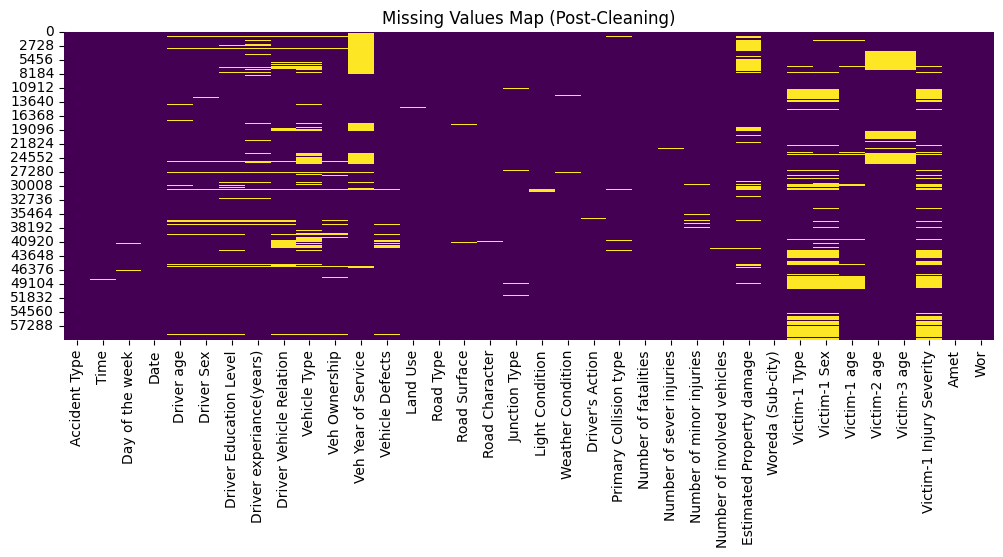

In [3]:
df_clean = clean_raw_data(df_raw)
print(f"Shape after cleaning: {df_clean.shape}")

# Visualize missing values after cleaning
plt.figure(figsize=(12, 4))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Map (Post-Cleaning)")
plt.show()

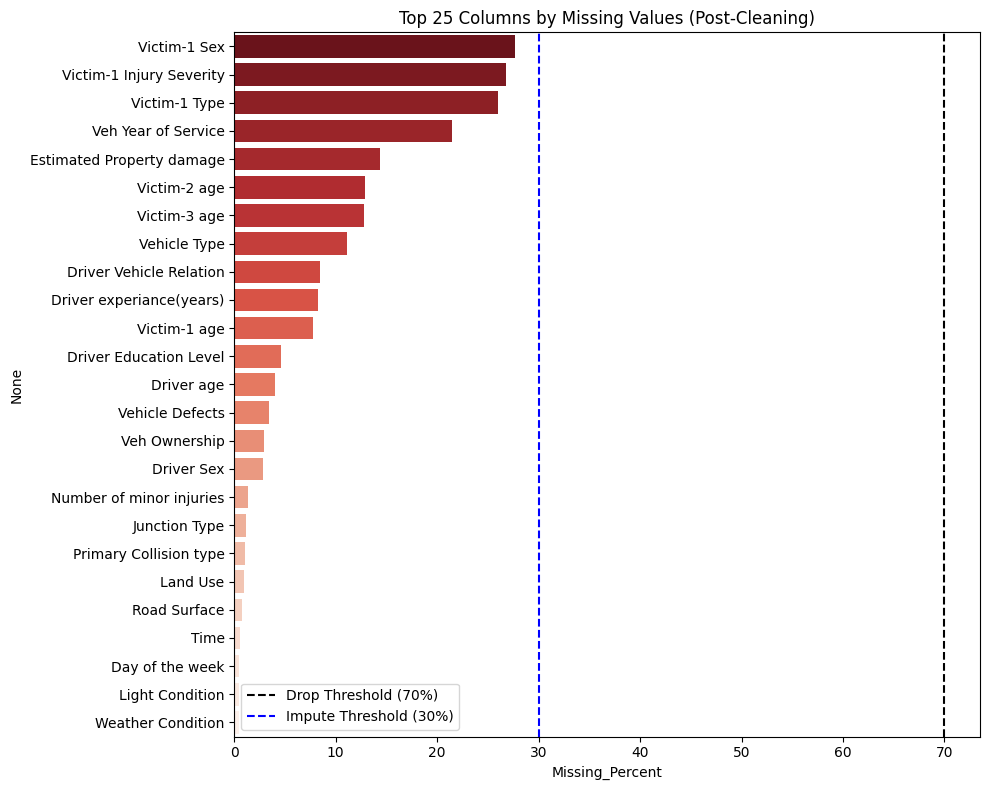

Columns to DROP (>70% Missing):
[]

Shape after dropping columns: (60004, 36)


In [6]:
# Calculate Missing Percentage
missing_percent = df_clean.isnull().mean() * 100
missing_df = pd.DataFrame(missing_percent, columns=['Missing_Percent']).sort_values(by='Missing_Percent', ascending=False)

# Visualize Top 20 Missing Columns
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Missing_Percent',
    y=missing_df.index[:25],
    hue=missing_df.index[:25],  # <-- assign y variable to hue
    data=missing_df[:25],
    palette='Reds_r',
    legend=False
)
plt.title("Top 25 Columns by Missing Values (Post-Cleaning)")
plt.axvline(70, color='black', linestyle='--', label='Drop Threshold (70%)')
plt.axvline(30, color='blue', linestyle='--', label='Impute Threshold (30%)')
plt.legend()
plt.tight_layout()
plt.show()

print("Columns to DROP (>70% Missing):")
cols_to_drop = missing_df[missing_df['Missing_Percent'] > 70].index.tolist()
print(cols_to_drop)

# Drop them for the rest of EDA
df_eda = df_clean.drop(columns=cols_to_drop)
print(f"\nShape after dropping columns: {df_eda.shape}")

## 3. Feature Engineering
Apply feature engineering (Time cyclical encoding).


In [7]:
df_eng = feature_engineering(df_clean)
print(f"Shape after Feature Engineering: {df_eng.shape}")
print("New Features:", [c for c in df_eng.columns if c not in df_clean.columns])

# Check the new Time features
df_eng[['Hour_Sin', 'Hour_Cos']].head()

Shape after Feature Engineering: (60004, 37)
New Features: ['Hour_Sin', 'Hour_Cos']


,Hour_Sin,Hour_Cos
0,-0.707107,-0.707107
1,0.707107,-0.707107
2,0.965926,-0.258819
3,-0.500000,0.866025
4,-0.500000,-0.866025


## 4. Splitting & Preprocessing Pipeline
 
 1.  **Split**: 70% Train, 15% Validation, 15% Test.
 2.  **Imputation**: Median (Numeric), Mode (Categorical).
 3.  **Scaling**: Standard Scaler (Numeric).
 4.  **Encoding**: One-Hot Encoding (Categorical).
 
 *Note: The preprocessor is fit ONLY on the Training set to prevent data leakage.*

In [8]:
data_splits = get_processed_data(df_eng, target_col='Accident Type', test_size=0.15, val_size=0.15)

X_train = data_splits['X_train']
X_val = data_splits['X_val']
X_test = data_splits['X_test']
y_train = data_splits['y_train']
y_val = data_splits['y_val']
y_test = data_splits['y_test']

print(f"Training Shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation Shape: X_val={X_val.shape},y_val={y_val.shape}")
print(f"Test Shape: X_test={X_test.shape},y_test={y_test.shape}")

# Verify Label Encoding Classes
le = data_splits['label_encoder']
print(f"Target Classes: {le.classes_}")

Training Shape: X_train=(41986, 168), y_train=(41986, 1)
Validation Shape: X_val=(8997, 168),y_val=(8997, 1)
Test Shape: X_test=(8998, 168),y_test=(8998, 1)
Target Classes: ['Fatal' 'Minor' 'PDO' 'Serious']


## 5. Save Processed Data (Parquet)
Save the final processed arrays as Parquet files for the Model Design phase.


In [9]:
# Save splits to Parquet
X_train.to_parquet(PROCESSED_DIR / "X_train.parquet", index=False)
X_val.to_parquet(PROCESSED_DIR / "X_val.parquet", index=False)
X_test.to_parquet(PROCESSED_DIR / "X_test.parquet", index=False)

y_train.to_parquet(PROCESSED_DIR / "y_train.parquet", index=False)
y_val.to_parquet(PROCESSED_DIR / "y_val.parquet", index=False)
y_test.to_parquet(PROCESSED_DIR / "y_test.parquet", index=False)

print(f"Data saved to {PROCESSED_DIR}")

Data saved to /home/alazar/dev/crash-learner/data/processed


### Summary of Data Preparation
 
 *   **Input:** Raw Excel with 50+ columns and significant missing data.
 *   **Cleaning:** Dropped 20+ sparse columns, fixed typos (e.g., 'Augest', 'Privategg'), handled outliers (Age 450).
 *   **Engineering:** Converted linear Time to Cyclical Hour (Sin/Cos).
 *   **Preprocessing:** Imputed missing values, Scaled numerics, One-Hot encoded categoricals.
 *   **Output:** Cleaned, Scaled, and Encoded Parquet files ready for Neural Network training.